# Composite score of accuracy and robustness/consistency.

We used the RMSE and Pearson scores with the simulation experiments (described above), along with the robustness/consistency measures per patient and per transform (described above) to get a new composite score per transform.

For each simulation dataset (ADP, PBMC, MSB, MBC) we took every held‐out‐cell evaluation (per‐sample Pearson r and RMSE), min–max–scaled each metric to [0,1] (inverting RMSE), and then averaged across all samples of the same transform to yield one normalized Pearson and one normalized RMSE per transform per dataset. We then collapsed across the four datasets by taking the mean of each transform’s normalized Pearson and normalized RMSE, and finally defined a single “accuracy” score for each transform as the arithmetic mean of its two normalized metrics. This produces one composite accuracy score ∈ [0,1] per transform, equally weighting correlation and error across all datasets.

For each reference transformation, we quantified its consistency along two orthogonal axes (across donors and across transforms) and then combined them into a single “consistency score.” First, from the pair-wise donor-to-donor similarity table (all cosine similarities between every two donors’ predicted proportion vectors for a given transform), we min–max scaled those cosine values to [0, 1] and averaged them to yield a per-donor score for each transform. Second, from a transform-to-transform cosine‐similarity matrix (excluding self‐comparisons), we likewise flattened the off-diagonal entries into a long list, applied the same min–max scaling, and averaged per transform to obtain a per-transform score. Finally, we defined the overall “robustness score” as the simple mean of the per-donor score and per-transform score, thereby giving equal weight to between-donor and between-reference agreement. This gave us two normalized values per transform; one that shows the accuracy seen in pseudobulk experiment, and one that shows the robustness in real data. 

- Results: . We found one cluster of the most robust transforms that includes, in order: -DEG Intersection, scVILS, scVIcond, S-Nuc and PCA. Surprisingly, the removal of random genes (-Random Genes) had high values across both axes too.

## Imports and settings

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# =========================
# Settings
# =========================

datasets = ["ADP", "PBMC", "MSB", "MBC"]

display_names = {
    "rawSN": "snRNA",
    "degSN": "snRNA (-DEG)",
    "degOtherSN": "-DEG Other Datasets",
    "degIntSN": "-DEG Int.",
    "degRandSN": "-Random Genes",
    "pcaSN": "PCA",
    "degPCA_SN": "PCA (-DEG)",
    "scvi_LSshift_SN": "scVILS",
    "degScviLSshift_SN": "scVILS (-DEG)",
    "scviSN": "scVIcond",
    "degScviSN": "scVIcond (-DEG)",
    "degIntAllSN": "snRNA All (-DEG Int.)",
}

# Palettes & transform names
display_palette = {
    "snRNA": "rosybrown",
    "PCA": "#2ca02c",
    "scVILS": "darkorange",
    "scVIcond": "#9467bd",
    "snRNA (-DEG)": "lightcoral",
    "PCA (-DEG)": "#98df8a",
    "scVILS (-DEG)": "sandybrown",
    "scVIcond (-DEG)": "#c5b0d5",
    "-DEG Other Datasets": "sandybrown",
    "-DEG Int.": "tomato",
    "-Random Genes": "chocolate",
    "snRNA All (-DEG Int.)": "m",
}

## Load data

In [4]:
# 1) Load per-dataset simulation accuracy (Pearson & RMSE) tables
eval_dfs = {}
for ds in datasets:
    fp = os.path.join("..", "results", ds, f"evaluation_{ds}.csv")
    if not os.path.exists(fp):
        raise FileNotFoundError(f"Missing evaluation file for {ds}: {fp}")
    eval_dfs[ds] = pd.read_csv(fp)
eval_dfs["ADP"].Transform.unique()

array(['degIntAllSN', 'degIntSN', 'degOtherSN', 'degPCA_SN', 'degRandSN',
       'degSN', 'degScviLSshift_SN', 'degScviSN', 'pcaSN', 'rawSN',
       'sc_raw', 'scviSN', 'scvi_LSshift_SN', 'sn_raw'], dtype=object)

In [5]:
# 2) Load inter-patient (per-donor) pairwise cosine similarities
donor_consistency = pd.read_csv(
    os.path.join("..", "results", "Real_ADP", "donor_pairwise_consistency.csv")
)

# 3) Load inter-transform pairwise cosine similarities
#    saved with transforms as both rows and columns
transform_consistency = pd.read_csv(
    os.path.join("..", "results", "Real_ADP", "transform_pairwise_consistency.csv"),
    index_col=0,
)
transform_consistency.columns = transform_consistency.columns.str.replace(
    "degpcaSN", "degPCA_SN"
)
transform_consistency.index = transform_consistency.index.str.replace(
    "degpcaSN", "degPCA_SN"
)

# Quick sanity-check prints
print("Simulation eval shapes:")
for ds, df in eval_dfs.items():
    print(f"  {ds}: {df.shape}")
print("Donor consistency:", donor_consistency.shape)
print("Transform consistency:", transform_consistency.shape)

# Now `all_eval`, `donor_consistency` and `transform_consistency`
# are O.K for the normalization, aggregation, and plotting below

Simulation eval shapes:
  ADP: (14000, 4)
  PBMC: (14000, 4)
  MSB: (11000, 4)
  MBC: (14000, 4)
Donor consistency: (792, 3)
Transform consistency: (12, 12)


**Simulation eval shapes**

Each evaluation_{DS}.csv has one row per (SampleID × CellType × Transform). For ADP, ~79 000 rows means ADP had ~7 182 sample–cell pairs × 11 transforms ≈ 79 000. PBMC, MSB, MBC similarly line up with their numbers of pseudobulk samples and transforms.

**Donor consistency**

We have 726 rows in donor_pairwise_consistency.csv. That equals 11 transforms × C( n_donors, 2 ) donor–donor pairs (for Real_ADP, n_donors = 12 → C(12,2)=66; 66×11=726).

**Transform consistency**

A square 11×11 matrix, one cosine for each (transform_i, transform_j) pair among the 11 transforms.

## Normalization, calculation and combining

In [6]:
def process_results(eval_dfs):
    norm_summaries = []

    for ds, df in eval_dfs.items():

        if "RMSE_NonRemoved" in df.columns:
            df["RMSE"] = df["RMSE_NonRemoved"]
            df["Pearson"] = df["Pearson_NonRemoved"]
        elif "RMSE_RemovedOnly" in df.columns:
            df["RMSE"] = df["RMSE_RemovedOnly"]
            df["Pearson"] = df["Pearson_RemovedOnly"]

        # 1) find the full Pearson & RMSE ranges
        p_min, p_max = df["Pearson"].min(), df["Pearson"].max()
        r_min, r_max = df["RMSE"].min(), df["RMSE"].max()

        # 2) normalize each sample‐row
        df = df.copy()
        df["pearson_norm"] = (df["Pearson"] - p_min) / (p_max - p_min)
        # invert RMSE so “higher is better,” then scale
        df["rmse_norm"] = (r_max - df["RMSE"]) / (r_max - r_min)

        # 3) now collapse to one summary per transform by *median*
        grp = (
            df.groupby("Transform")
            .agg(
                pearson_norm=("pearson_norm", "mean"),
                rmse_norm=("rmse_norm", "mean"),
                n_samples=("Pearson", "size"),
            )
            .reset_index()
        )
        grp["Dataset"] = ds
        norm_summaries.append(grp)

    norm_df = pd.concat(norm_summaries, ignore_index=True)

    # in this case, the controls are not comparable so we remove.
    sim_df = norm_df[~norm_df["Transform"].isin(["sc_raw", "sn_raw"])]
    # 1) collapse across datasets
    sim_df = sim_df.groupby("Transform")[["pearson_norm", "rmse_norm"]].mean()

    # 2) combine into one accuracy score
    sim_df["accuracy_score"] = sim_df[["pearson_norm", "rmse_norm"]].mean(axis=1)
    sim_df["Transform"] = sim_df.index.map(display_names)
    sim_df.index = sim_df["Transform"]
    # done – one row per transform
    print(sim_df.sort_values("accuracy_score", ascending=False))

    return sim_df

In [7]:
sim_df = process_results(eval_dfs)

                       pearson_norm  rmse_norm  accuracy_score  \
Transform                                                        
snRNA (-DEG)               0.828706   0.765302        0.797004   
-DEG Other Datasets        0.828386   0.759219        0.793802   
-DEG Int.                  0.812195   0.744606        0.778401   
scVIcond                   0.816065   0.735522        0.775794   
scVIcond (-DEG)            0.804070   0.745890        0.774980   
PCA (-DEG)                 0.800006   0.736400        0.768203   
scVILS (-DEG)              0.787564   0.716694        0.752129   
PCA                        0.785321   0.709760        0.747540   
-Random Genes              0.787133   0.698515        0.742824   
snRNA                      0.787471   0.695075        0.741273   
scVILS                     0.778421   0.679713        0.729067   
snRNA All (-DEG Int.)      0.630407   0.606979        0.618693   

                                   Transform  
Transform                   

In [8]:
# —————————————————————————————————————————————————————————————
# Flatten transform_consistency to a long table (exclude self‐similarity)
# —————————————————————————————————————————————————————————————
rows = []
for t1 in transform_consistency.index:
    for t2 in transform_consistency.columns:
        if t1 == t2:
            continue
        rows.append({"Transform": t1, "Cosine": transform_consistency.loc[t1, t2]})
transform_long = pd.DataFrame(rows)

# —————————————————————————————————————————————————————————————
# Min–max normalize each Cosine distribution to [0,1]
#    so “higher = more consistent”
# —————————————————————————————————————————————————————————————
# donor
d_min, d_max = donor_consistency["Cosine"].min(), donor_consistency["Cosine"].max()
donor_consistency["cosine_norm"] = (donor_consistency["Cosine"] - d_min) / (
    d_max - d_min
)

# transform
t_min, t_max = transform_long["Cosine"].min(), transform_long["Cosine"].max()
transform_long["cosine_norm"] = (transform_long["Cosine"] - t_min) / (t_max - t_min)

# —————————————————————————————————————————————————————————————
# Collapse each to one mean normalized‐consistency per transform
# —————————————————————————————————————————————————————————————
donor_score = (
    donor_consistency.groupby("Transform")["cosine_norm"]
    .mean()
    .reset_index(name="donor_score")
)

transform_score = (
    transform_long.groupby("Transform")["cosine_norm"]
    .mean()
    .reset_index(name="transform_score")
)

# —————————————————————————————————————————————————————————————
# Merge and compute overall consistency score (equal weights)
# —————————————————————————————————————————————————————————————
consistency_df = donor_score.merge(transform_score, on="Transform")
consistency_df["consistency_score"] = consistency_df[
    ["donor_score", "transform_score"]
].mean(axis=1)

#  add display names if you have a mapping dict
consistency_df["Transform"] = consistency_df["Transform"].map(display_names)
consistency_df.index = consistency_df["Transform"]
print(consistency_df.sort_values("consistency_score", ascending=False))

                                   Transform  donor_score  transform_score  \
Transform                                                                    
-DEG Int.                          -DEG Int.     0.996525         0.736862   
scVILS                                scVILS     0.996731         0.685645   
snRNA                                  snRNA     0.998743         0.683440   
scVIcond                            scVIcond     0.996986         0.677404   
PCA                                      PCA     0.980192         0.687244   
-Random Genes                  -Random Genes     0.987004         0.669383   
snRNA (-DEG)                    snRNA (-DEG)     0.932340         0.695219   
-DEG Other Datasets      -DEG Other Datasets     0.993507         0.600402   
scVIcond (-DEG)              scVIcond (-DEG)     0.884145         0.707099   
scVILS (-DEG)                  scVILS (-DEG)     0.891608         0.638758   
PCA (-DEG)                        PCA (-DEG)     0.685258       

## X and Y composite score scatter

In [9]:
consistency_df = consistency_df.sort_index(ascending=True)
sim_df = sim_df.sort_index(ascending=True)

In [10]:
combo = pd.DataFrame(index=sim_df.index)
combo["accuracy_score"] = sim_df["accuracy_score"]
combo["consistency_score"] = consistency_df["consistency_score"]
combo["Transform"] = sim_df["Transform"]
combo

,accuracy_score,consistency_score,Transform
Transform,,,
-DEG Int.,0.778401,0.866693,-DEG Int.
-DEG Other Datasets,0.793802,0.796955,-DEG Other Datasets
-Random Genes,0.742824,0.828194,-Random Genes
PCA,0.747540,0.833718,PCA
PCA (-DEG),0.768203,0.497143,PCA (-DEG)
scVILS,0.729067,0.841188,scVILS
scVILS (-DEG),0.752129,0.765183,scVILS (-DEG)
scVIcond,0.775794,0.837195,scVIcond
scVIcond (-DEG),0.774980,0.795622,scVIcond (-DEG)


In [11]:
combo.sort_values(by="accuracy_score", ascending=False)

,accuracy_score,consistency_score,Transform
Transform,,,
snRNA (-DEG),0.797004,0.813779,snRNA (-DEG)
-DEG Other Datasets,0.793802,0.796955,-DEG Other Datasets
-DEG Int.,0.778401,0.866693,-DEG Int.
scVIcond,0.775794,0.837195,scVIcond
scVIcond (-DEG),0.774980,0.795622,scVIcond (-DEG)
PCA (-DEG),0.768203,0.497143,PCA (-DEG)
scVILS (-DEG),0.752129,0.765183,scVILS (-DEG)
PCA,0.747540,0.833718,PCA
-Random Genes,0.742824,0.828194,-Random Genes


In [12]:
combo.sort_values(by="consistency_score", ascending=False)

,accuracy_score,consistency_score,Transform
Transform,,,
-DEG Int.,0.778401,0.866693,-DEG Int.
scVILS,0.729067,0.841188,scVILS
snRNA,0.741273,0.841092,snRNA
scVIcond,0.775794,0.837195,scVIcond
PCA,0.747540,0.833718,PCA
-Random Genes,0.742824,0.828194,-Random Genes
snRNA (-DEG),0.797004,0.813779,snRNA (-DEG)
-DEG Other Datasets,0.793802,0.796955,-DEG Other Datasets
scVIcond (-DEG),0.774980,0.795622,scVIcond (-DEG)


In [13]:
# define default text‐offsets for each label
text_offsets = {
    "snRNA": (0.03,0),
    "snRNA (-DEG)": (-0.01, -0.01),
    "-DEG Int.": (0, 0.01),
    "-DEG Other Datasets": (0, -0.01),  
    "-Random Genes": (-0.01, -0.01),  
    "PCA": (-0.01, 0.01),
    "PCA (-DEG)":(0, 0),  
    "scVILS": (0, 0.01),
    "scVILS (-DEG)": (-0.01, -0.01),  
    "scVIcond":(0.01, -0.01),
    "scVIcond (-DEG)":(-0.01, 0.01),  
    "snRNA All (-DEG Int.)": (0, 0), 
}

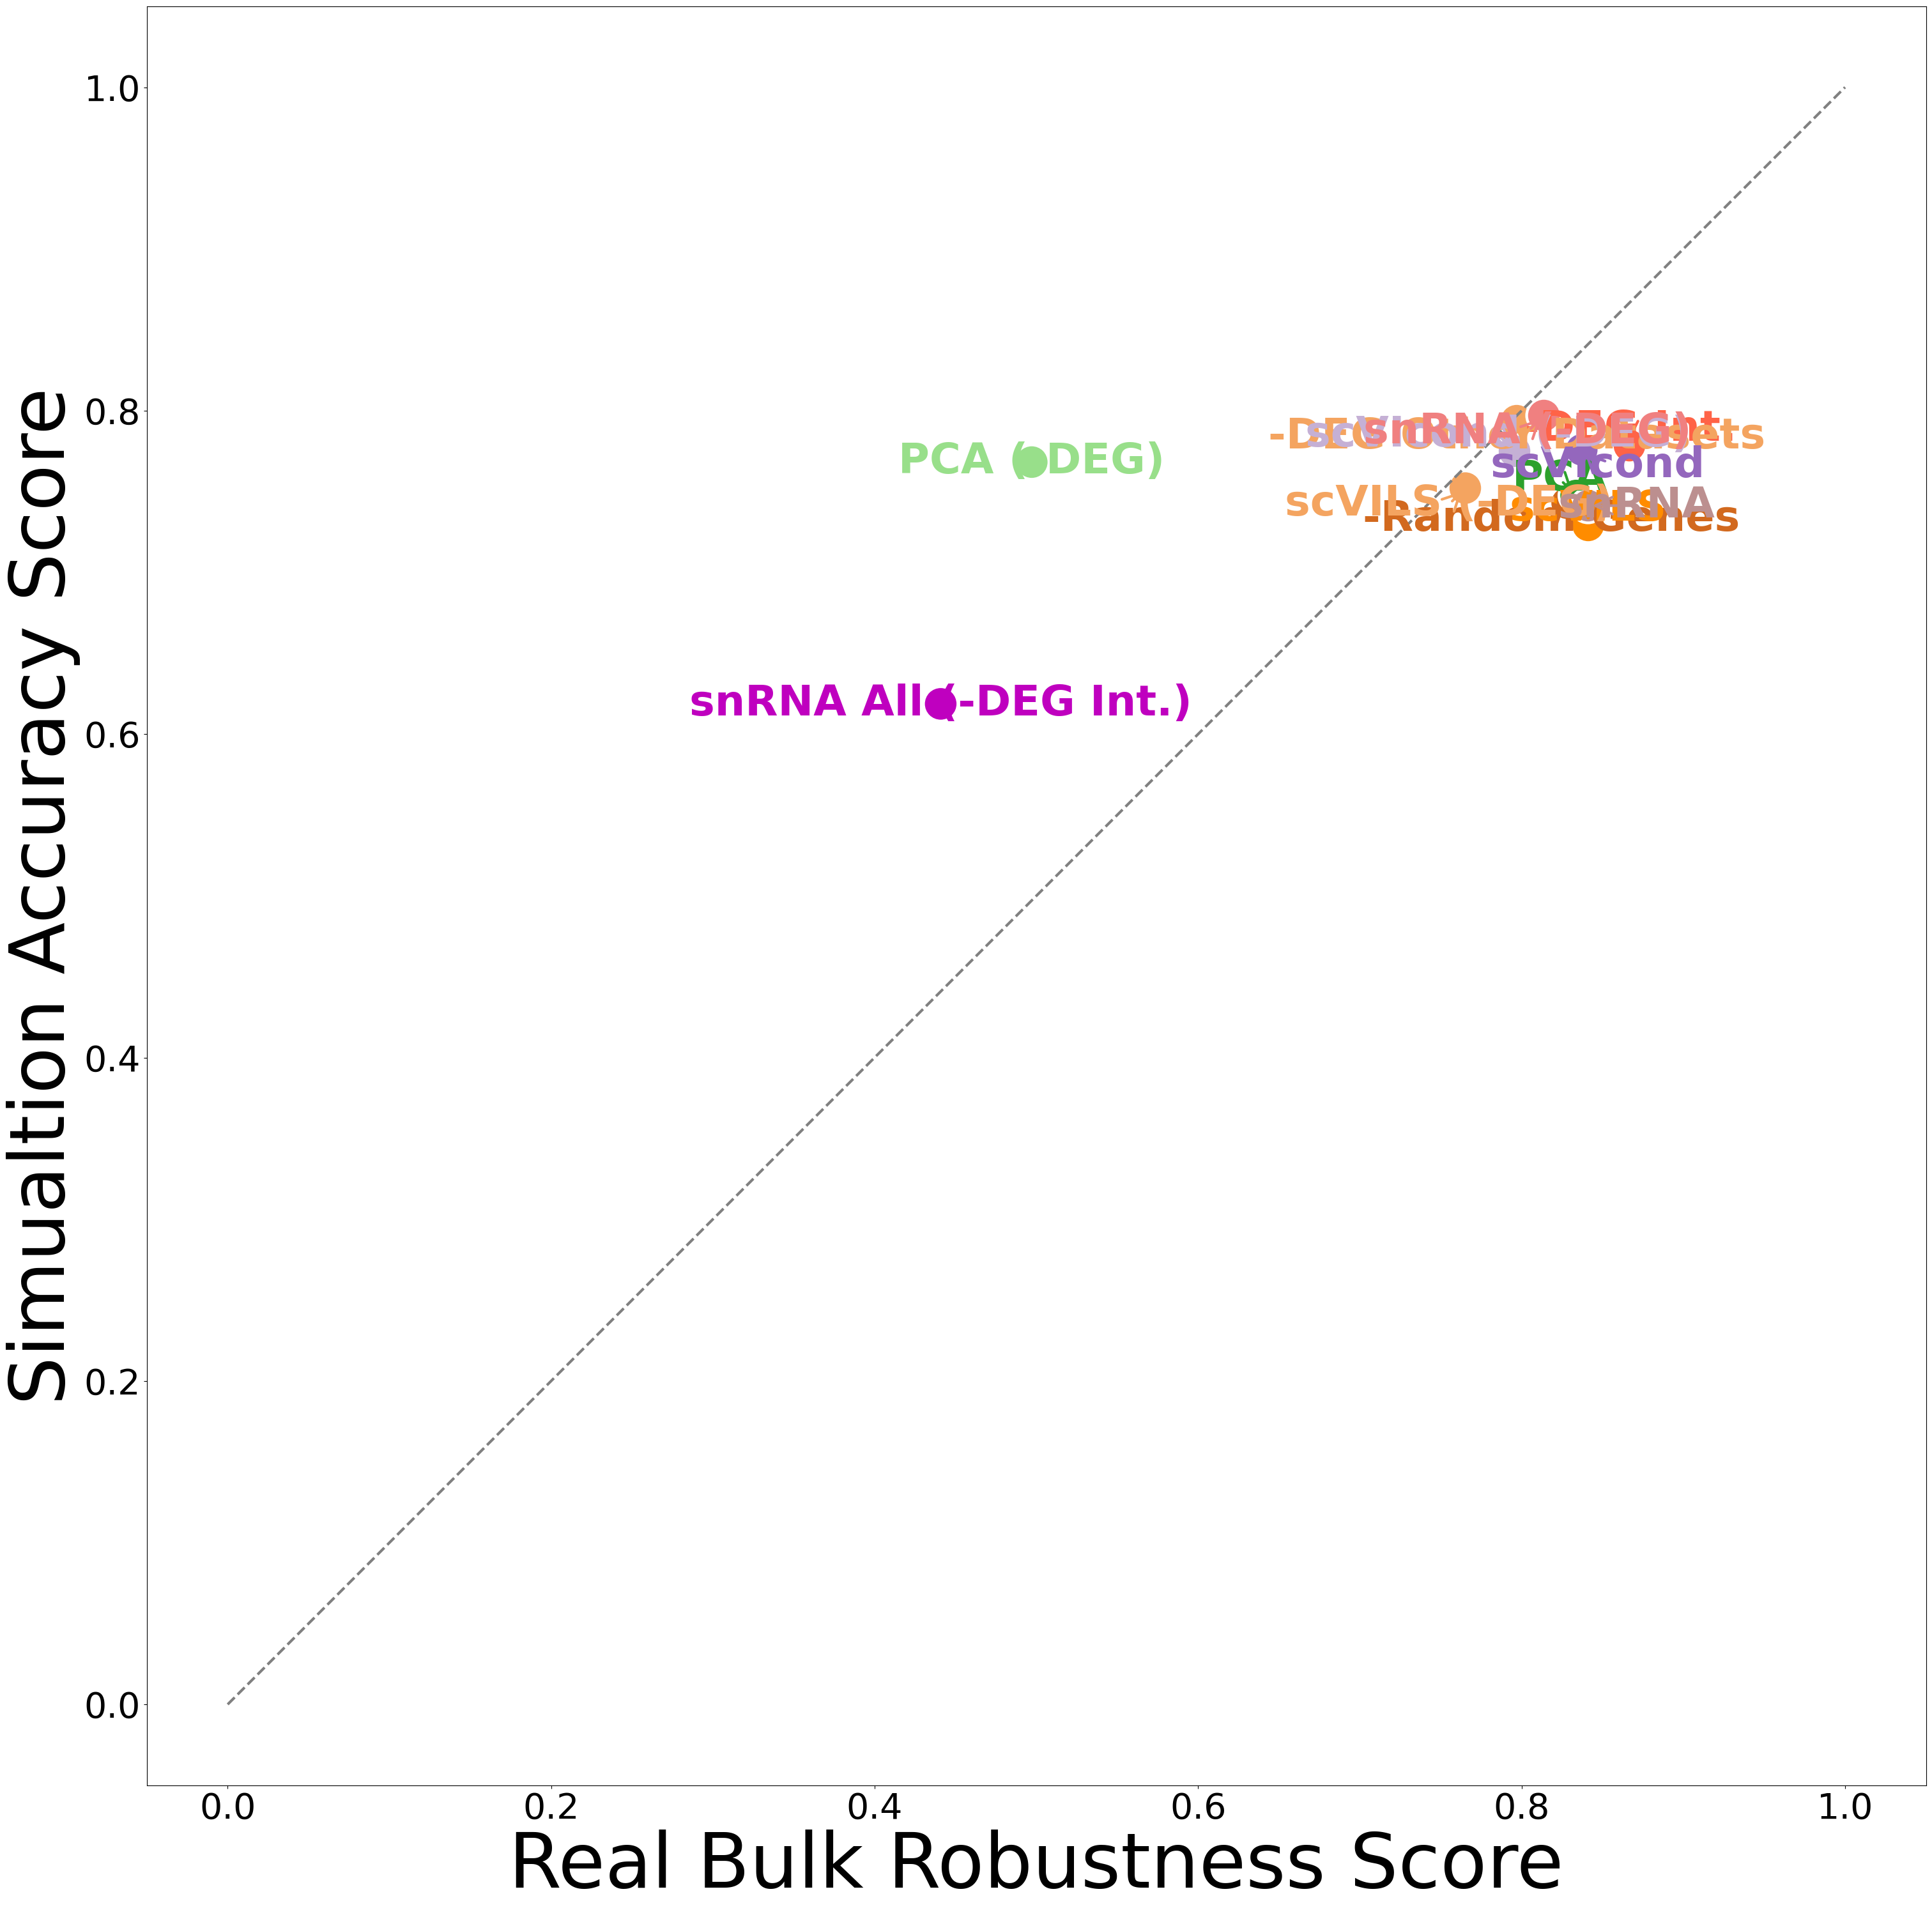

In [14]:
plt.figure(figsize=(32, 30))

plt.tight_layout()
ax = sns.scatterplot(
    x="consistency_score",
    y="accuracy_score",
    hue="Transform",
    data=combo,
    palette=display_palette,
    s=1500,
    legend=False,
)


# 2) annotate each point with its label at the offset, arrow in same color
for _, row in combo.iterrows():
    label = row["Transform"]
    x, y = row["consistency_score"], row["accuracy_score"]
    dx, dy = text_offsets.get(label, (0.05, 0.05))
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(x + dx, y + dy),
        textcoords="data",
        ha="center",
        va="center",
        fontsize=48,
        color=display_palette[label],
        weight="bold",
        arrowprops=dict(
            arrowstyle="->",
            color=display_palette[label],
            lw=3,
            shrinkA=5,
            shrinkB=5,
        ),
    )

# 3) add a y=x line for reference
ax.plot([0, 1], [0, 1], "--", linewidth=3, color="gray")
ax.set_aspect("equal")
ax.set_xlabel("Real Bulk Robustness Score", fontsize=86)
ax.set_ylabel("Simualtion Accuracy Score", fontsize=86)
# tightened limits (so the outliers truly sit outside)
ax.tick_params(axis="both", which="major", labelsize=40)
plt.tight_layout()
plt.show()

It'r difficult to see the differences. We'll cut the axes to max and add the outliers.

In [46]:
# define default text‐offsets for each label
text_offsets = {
    "snRNA": (0.015,0),
    "snRNA (-DEG)": (0.01, -0.01),
    "-DEG Int.": (0, 0.01),
    "-DEG Other Datasets": (-0.01, -0.01),  
    "-Random Genes": (-0.01, -0.01),  
    "PCA": (-0.01, 0.01),
    "PCA (-DEG)":(0, 0),  
    "scVILS": (0, -0.01),
    "scVILS (-DEG)": (0, -0.01),  
    "scVIcond":(0.01, -0.01),
    "scVIcond (-DEG)":(-0.01, -0.01),  
    "snRNA All (-DEG Int.)": (0, 0), 
}

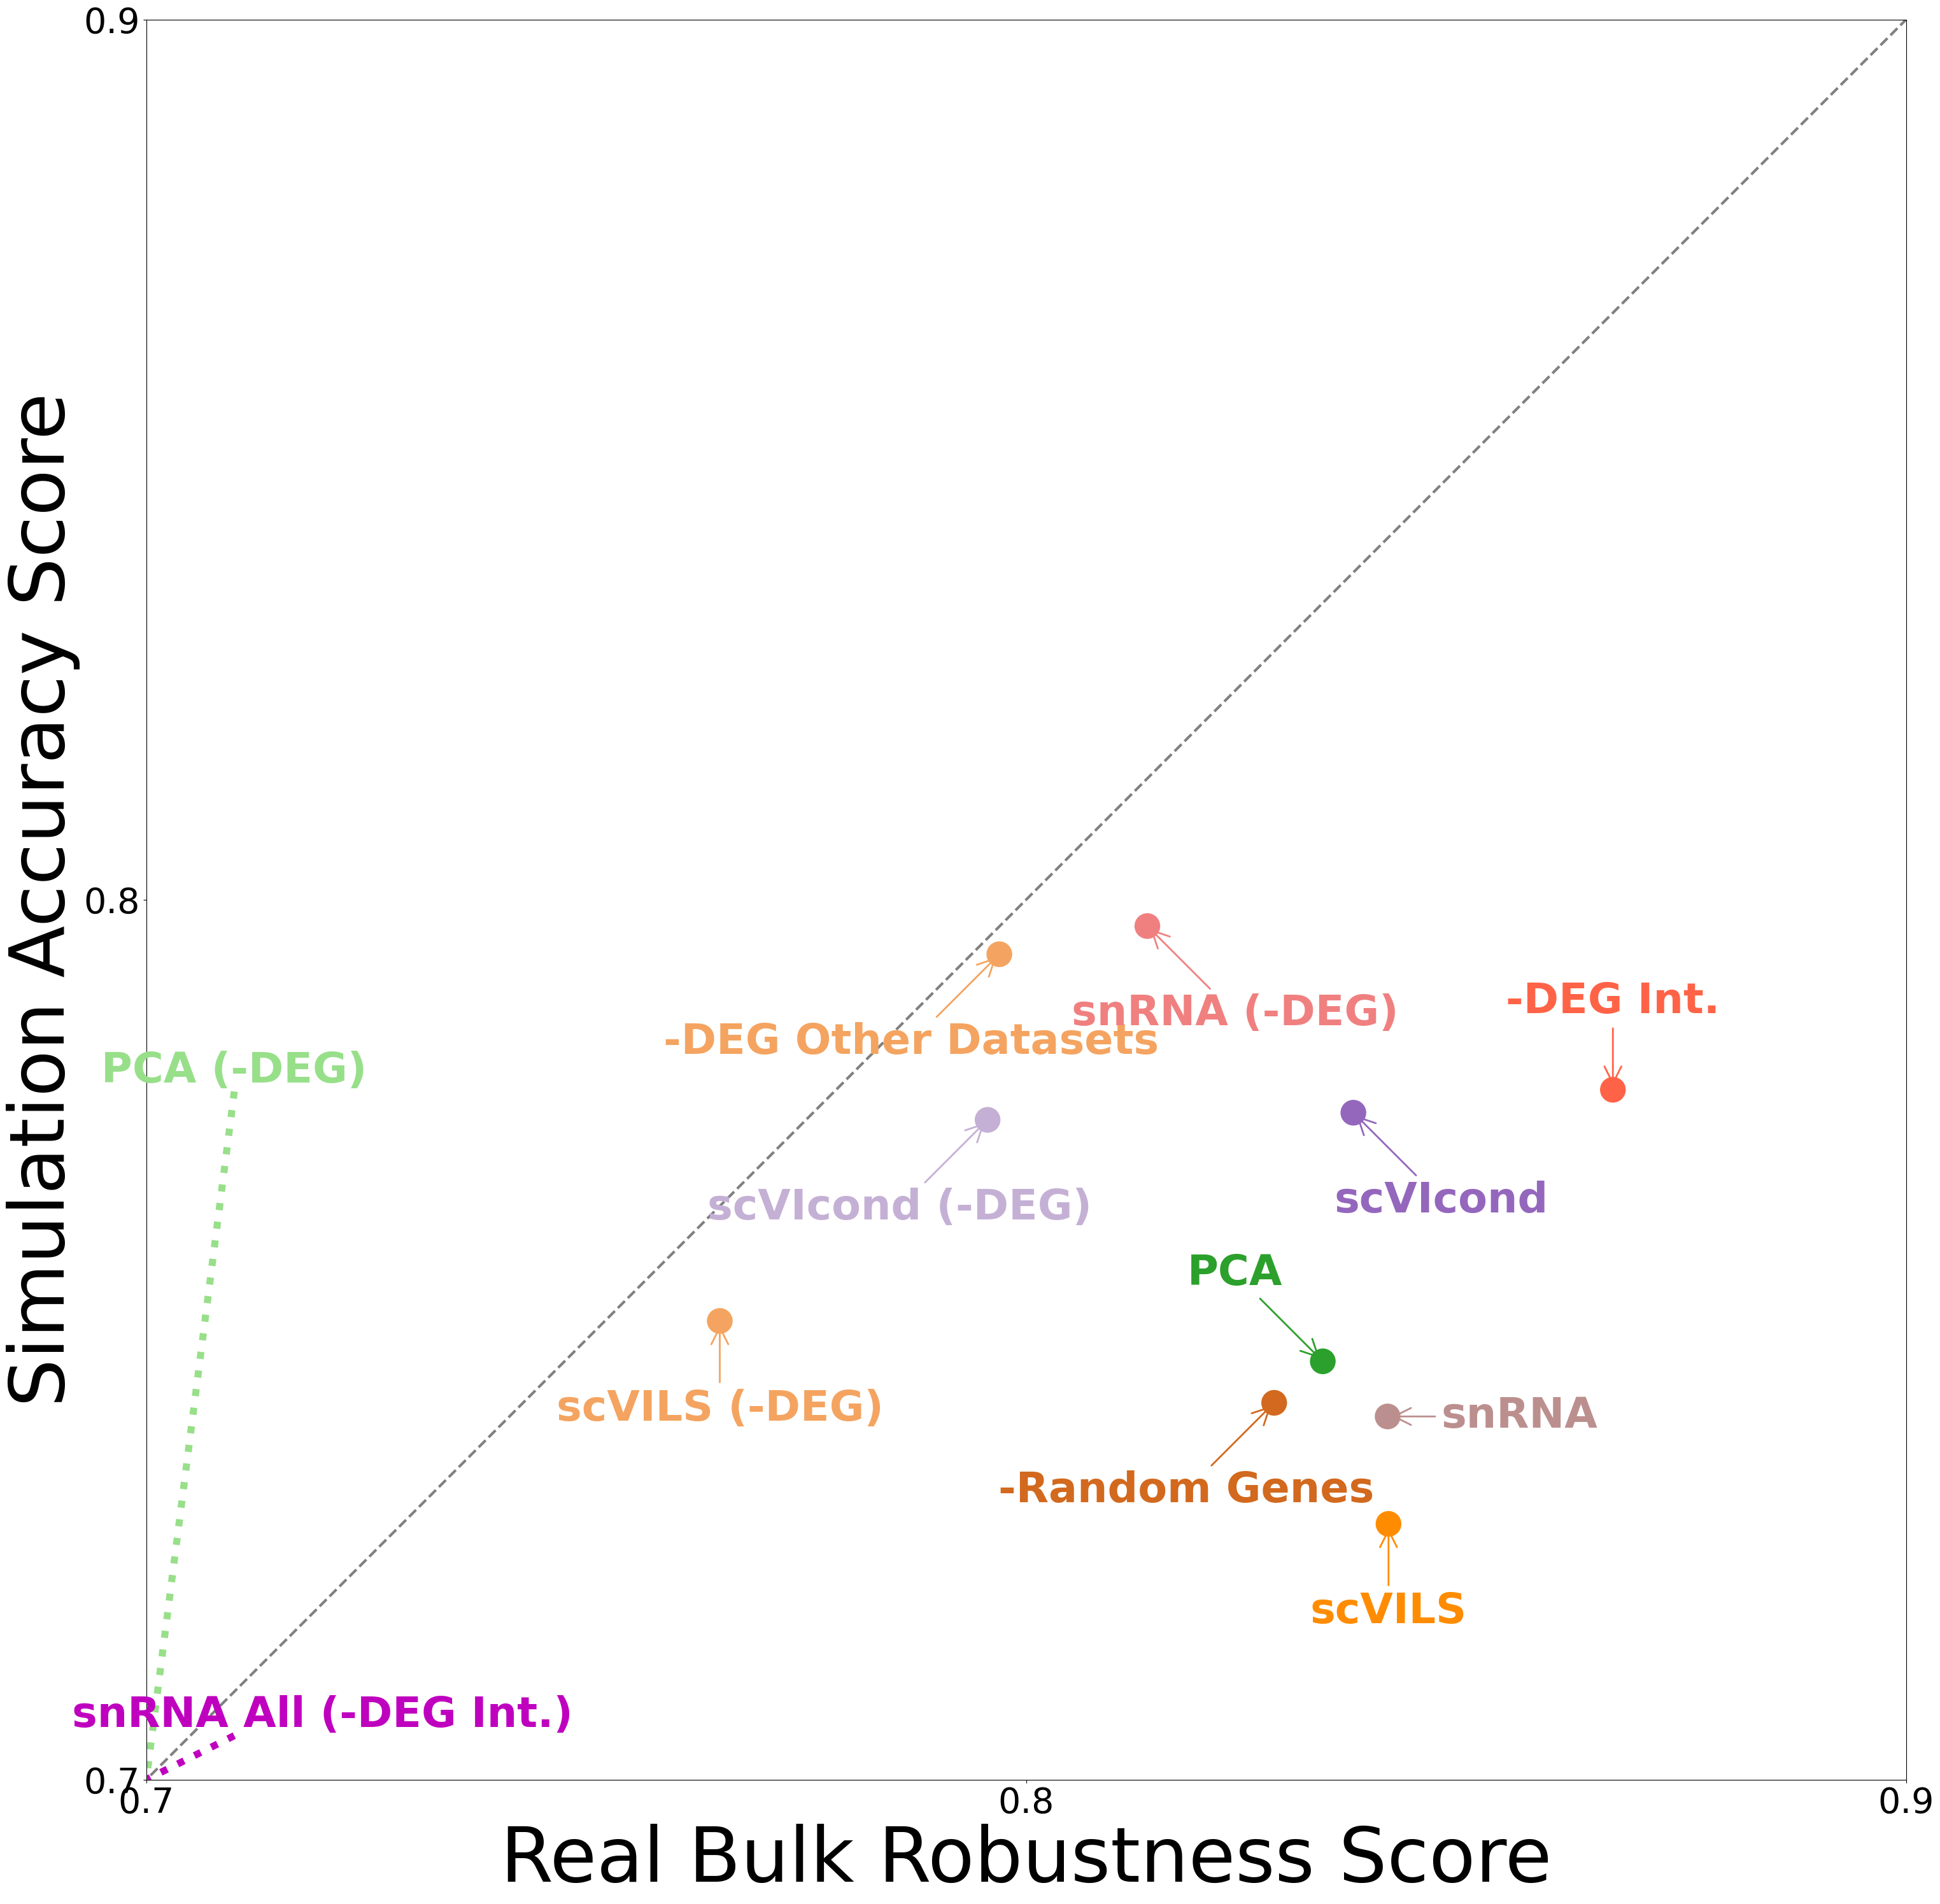

In [52]:
POINT_SIZE       = 1000
LABEL_SIZE       = 48
DOT_LINEWIDTH    = 2
AXIS_TITLE_SIZE  = 86
TICK_SIZE        = 40
df_scatter= combo.copy()
df_scatter["Display"] = df_scatter.Transform

off_label_offsets = {
    "PCA (-DEG)"            : 0.035,   # higher
    "snRNA All (-DEG Int.)" : 0.015,   # lower
}
# --------------------------------------------------
# make the base scatter of ALL in-frame points
# --------------------------------------------------
off_frame = ["PCA (-DEG)", "snRNA All (-DEG Int.)"]
df_in     = df_scatter[~df_scatter.Display.isin(off_frame)]
df_off    = df_scatter[df_scatter.Display.isin(off_frame)]

plt.figure(figsize=(32, 30))

ax = sns.scatterplot(
    data=df_in,
    x="consistency_score", y="accuracy_score",
    hue="Display",
    palette=display_palette,
    s=POINT_SIZE, legend=False,
)
ax.set_xlim(0.7, .9)
ax.set_ylim(0.7, .9)
# --------------------------------------------------
# annotate the in-frame dots with original offsets
# --------------------------------------------------
for _, row in df_in.iterrows():
    lbl = row["Display"]
    x, y = row["consistency_score"], row["accuracy_score"]
    dx, dy = text_offsets.get(lbl, (0.005, 0.005))
    ax.annotate(
        lbl, xy=(x, y), xytext=(x + dx, y + dy),
        ha="center", va="center",
        fontsize=LABEL_SIZE, weight="bold",
        color=display_palette[lbl],
        arrowprops=dict(arrowstyle="->",
                        color=display_palette[lbl],
                        lw=DOT_LINEWIDTH,
                        shrinkA=5, shrinkB=5),
    )

# --------------------------------------------------
#  add dotted guide + label for the two off-frame pts
# --------------------------------------------------
# after drawing all in‑frame points
x_min, x_max = ax.get_xlim()
y_bottom_vals = {"PCA (-DEG)": df_off.loc["PCA (-DEG)"].accuracy_score, "snRNA All (-DEG Int.)":0.7}
x_bottom_vals = {"PCA (-DEG)": 0.7, "snRNA All (-DEG Int.)":0.7}
delta = 0.01
x_min, x_max = ax.get_xlim()   # (0.7, 0.9)
y_min, y_max = ax.get_ylim()   # (0.7, 0.9)
# extra nudges -------------------------------------------------------------
extra_y_shift = {"snRNA All (-DEG Int.)": -0.005}   # already in use
extra_x_shift = {"snRNA All (-DEG Int.)":  0.010}  

for _, row in df_off.iterrows():
    lbl = row["Display"]

    # guide anchor (stays put)
    x_lab_base = x_bottom_vals[lbl] + delta        # 0.71 for both off‑frame pts
    y_lab      = y_bottom_vals[lbl] + delta + extra_y_shift.get(lbl, 0.0)

    ax.plot([x_lab_base, x_min],
            [y_lab,        y_min],
            linestyle=":", lw=DOT_LINEWIDTH*4,
            color=display_palette[lbl])

    y_bottom = y_bottom_vals[lbl]
    x_bottom = x_bottom_vals[lbl]

    x_true, y_true = row["consistency_score"], row["accuracy_score"]
    dy    = off_label_offsets[lbl]            # label lift

    x_lab_text = x_lab_base + extra_x_shift.get(lbl, 0.0)
    ax.text(x_lab_text, y_lab,
            lbl, ha="center", va="bottom",
            fontsize=LABEL_SIZE, weight="bold",
            color=display_palette[lbl])
            
# --------------------------------------------------
# cosmetics 
# --------------------------------------------------
ax.set_aspect("equal", adjustable="box")
ax.plot([0, 1.015], [0, 1.015], "--", lw=3, color="gray")
ax.set_xlabel("Real Bulk Robustness Score", fontsize=AXIS_TITLE_SIZE)
ax.set_ylabel("Simulation Accuracy Score",  fontsize=AXIS_TITLE_SIZE)
ax.tick_params(axis="both", labelsize=TICK_SIZE)

ax.set_xticks([0.7, 0.8, 0.9])
ax.set_yticks([0.7, 0.8, .9])

plt.tight_layout()
plt.show()